In [1]:
from sklearn.cluster import KMeans
import numpy as np
import csv
import math
import matplotlib.pyplot
from matplotlib import pyplot as plt

In [2]:
maxAcc = 0.0
maxIter = 0
C_Lambda = 0.9
TrainingPercent = 80
ValidationPercent = 10
TestPercent = 10
M = 2
PHI = []
IsSynthetic = False

In [3]:
def GetTargetVector(filePath):
    t = []
    with open(filePath, 'rU') as f:
        reader = csv.reader(f)
        for row in reader:  
            t.append(int(row[0]))
            #print(int(row[0]))
    #print("Raw Training Generated..")
    return t

def GenerateRawData(filePath, IsSynthetic):    
    dataMatrix = [] 
    with open(filePath, 'rU') as fi:
        reader = csv.reader(fi)
        for row in reader:
            dataRow = []
            for column in row:
                dataRow.append(float(column))
            dataMatrix.append(dataRow) 
            #print(dataRow)
    
    if IsSynthetic == False :
        dataMatrix = np.delete(dataMatrix, [5,6,7,8,9], axis=1)
   # print(dataMatrix.shape)
    dataMatrix = np.transpose(dataMatrix)  
   # print(dataMatrix.shape)
    #print ("Data Matrix Generated..")
    return dataMatrix

def GenerateTrainingTarget(rawTraining,TrainingPercent = 80):
    TrainingLen = int(math.ceil(len(rawTraining)*(TrainingPercent*0.01)))
    t           = rawTraining[:TrainingLen]
    #print(str(TrainingPercent) + "% Training Target Generated..")
    #print(t)
    #print(TrainingLen)
    return t

def GenerateTrainingDataMatrix(rawData, TrainingPercent = 80):
    T_len = int(math.ceil(len(rawData[0])*0.01*TrainingPercent))
    d2 = rawData[:,0:T_len]
    #print(str(TrainingPercent) + "% Training Data Generated..")
    #print(T_len)
    return d2

def GenerateValData(rawData, ValPercent, TrainingCount): 
    valSize = int(math.ceil(len(rawData[0])*ValPercent*0.01))
    V_End = TrainingCount + valSize
    dataMatrix = rawData[:,TrainingCount+1:V_End]
    #print (str(ValPercent) + "% Val Data Generated..")  
    return dataMatrix

def GenerateValTargetVector(rawData, ValPercent, TrainingCount): 
    valSize = int(math.ceil(len(rawData)*ValPercent*0.01))
    V_End = TrainingCount + valSize
    t =rawData[TrainingCount+1:V_End]
    #print (str(ValPercent) + "% Val Target Data Generated..")
    return t

#not using parameter MuMatrix,redundant parameter
def GenerateBigSigma(Data, MuMatrix,TrainingPercent,IsSynthetic):
    BigSigma    = np.zeros((len(Data),len(Data)))
    DataT       = np.transpose(Data)
    TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01))        
    varVect     = []
    for i in range(0,len(DataT[0])):
        vct = []
        for j in range(0,int(TrainingLen)):
            vct.append(Data[i][j])    
        varVect.append(np.var(vct))
    
    for j in range(len(Data)):
        BigSigma[j][j] = varVect[j]
    if IsSynthetic == True:
        BigSigma = np.dot(3,BigSigma)
    else:
        BigSigma = np.dot(200,BigSigma)
    ##print ("BigSigma Generated..")
    #print(BigSigma)
    return BigSigma

def GetScalar(DataRow,MuRow, BigSigInv):  
    R = np.subtract(DataRow,MuRow)
    T = np.dot(BigSigInv,np.transpose(R))  
    L = np.dot(R,T)
    return L

def GetRadialBasisOut(DataRow,MuRow, BigSigInv):    
    phi_x = math.exp(-0.5*GetScalar(DataRow,MuRow,BigSigInv))
    return phi_x

def GetPhiMatrix(Data, MuMatrix, BigSigma, TrainingPercent = 80):
    DataT = np.transpose(Data)
    TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01))         
    PHI = np.zeros((int(TrainingLen),len(MuMatrix))) 
    BigSigInv = np.linalg.inv(BigSigma)
    for  C in range(0,len(MuMatrix)):
        for R in range(0,int(TrainingLen)):
            PHI[R][C] = GetRadialBasisOut(DataT[R], MuMatrix[C], BigSigInv)
    #print ("PHI Generated..")
    return PHI

def GetWeightsClosedForm(PHI, T, Lambda):
    Lambda_I = np.identity(len(PHI[0]))
    for i in range(0,len(PHI[0])):
        Lambda_I[i][i] = Lambda
    PHI_T       = np.transpose(PHI)
    PHI_SQR     = np.dot(PHI_T,PHI)
    PHI_SQR_LI  = np.add(Lambda_I,PHI_SQR)
    PHI_SQR_INV = np.linalg.inv(PHI_SQR_LI)
    INTER       = np.dot(PHI_SQR_INV, PHI_T)
    W           = np.dot(INTER, T)
    ##print ("Training Weights Generated..")
    return W

def GetPhiMatrix(Data, MuMatrix, BigSigma, TrainingPercent = 80):
    DataT = np.transpose(Data)
    TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01))         
    PHI = np.zeros((int(TrainingLen),len(MuMatrix))) 
    BigSigInv = np.linalg.inv(BigSigma)
    for  C in range(0,len(MuMatrix)):
        for R in range(0,int(TrainingLen)):
            PHI[R][C] = GetRadialBasisOut(DataT[R], MuMatrix[C], BigSigInv)
    #print ("PHI Generated..")
    return PHI

def GetValTest(VAL_PHI,W):
    Y = np.dot(W,np.transpose(VAL_PHI))
    ##print ("Test Out Generated..")
    return Y

def GetErms(VAL_TEST_OUT,ValDataAct):
    sum = 0.0
    t=0
    accuracy = 0.0
    counter = 0
    val = 0.0
    for i in range (0,len(VAL_TEST_OUT)):
        sum = sum + math.pow((ValDataAct[i] - VAL_TEST_OUT[i]),2)
        if(int(np.around(VAL_TEST_OUT[i], 0)) == ValDataAct[i]):
            counter+=1
    accuracy = (float((counter*100))/float(len(VAL_TEST_OUT)))
    ##print ("Accuracy Generated..")
    ##print ("Validation E_RMS : " + str(math.sqrt(sum/len(VAL_TEST_OUT))))
    return (str(accuracy) + ',' +  str(math.sqrt(sum/len(VAL_TEST_OUT))))

## Fetch and Prepare Dataset

In [4]:
RawTarget = GetTargetVector('Querylevelnorm_t.csv')
RawData   = GenerateRawData('Querylevelnorm_X.csv',IsSynthetic)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 'U' mode is deprecated
  This is separate from the ipykernel package so we can avoid doing imports until
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: 'U' mode is deprecated
  del sys.path[0]


## Prepare Training Data

In [5]:
TrainingTarget = np.array(GenerateTrainingTarget(RawTarget,TrainingPercent))
TrainingData   = GenerateTrainingDataMatrix(RawData,TrainingPercent)
print(TrainingTarget.shape)
print(TrainingData.shape)

(55699,)
(41, 55699)


## Prepare Validation Data

In [6]:
ValDataAct = np.array(GenerateValTargetVector(RawTarget,ValidationPercent, (len(TrainingTarget))))
ValData    = GenerateValData(RawData,ValidationPercent, (len(TrainingTarget)))
print(ValDataAct.shape)
print(ValData.shape)

(6962,)
(41, 6962)


## Prepare Test Data

In [7]:
TestDataAct = np.array(GenerateValTargetVector(RawTarget,TestPercent, (len(TrainingTarget)+len(ValDataAct))))
TestData = GenerateValData(RawData,TestPercent, (len(TrainingTarget)+len(ValDataAct)))
print(ValDataAct.shape)
print(ValData.shape)

(6962,)
(41, 6962)


## Closed Form Solution [Finding Weights using Moore- Penrose pseudo- Inverse Matrix]

['0.5627948138903859', '0.5627948187891327', '0.5627948325388945', '0.5627948550604329', '0.562794886275212', '0.5627949261053973', '0.5627949744738532', '0.5627950313041182', '0.5627950965204275', '0.5627951700476821', '0.5627952518114399', '0.5627953417379392', '0.5627954397540554', '0.5627955457873169', '0.5627956597658954', '0.5627957816185969', '0.562795911274852', '0.5627960486647079', '0.5627961937188487', '0.5627963463685502', '0.5627965065457031', '0.5627966741827864', '0.5627968492128788', '0.5627970315696458', '0.5627972211873303', '0.5627974180007612', '0.5627976219453205', '0.5627978329569683', '0.5627980509722201', '0.5627982759281412', '0.5627985077623556', '0.5627987464130217', '0.5627989918188356', '0.5627992439190211', '0.5627995026533584', '0.562799767962112', '0.5628000397860872', '0.5628003180665937', '0.5628006027454565', '0.5628008937649919', '0.5628011910680323', '0.5628014945978833', '0.5628018042983574', '0.5628021201137305', '0.5628024419887776', '0.562802769

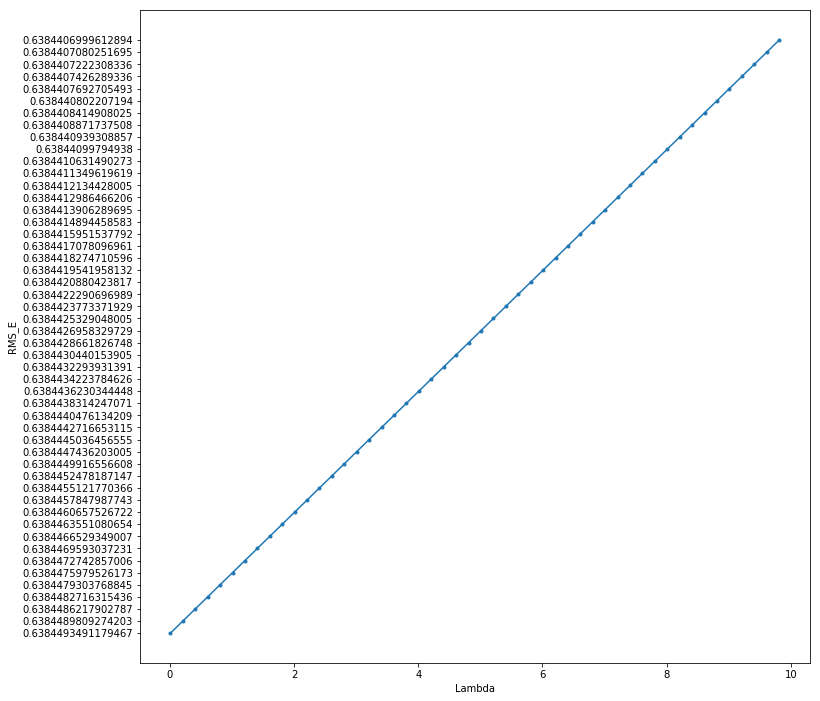

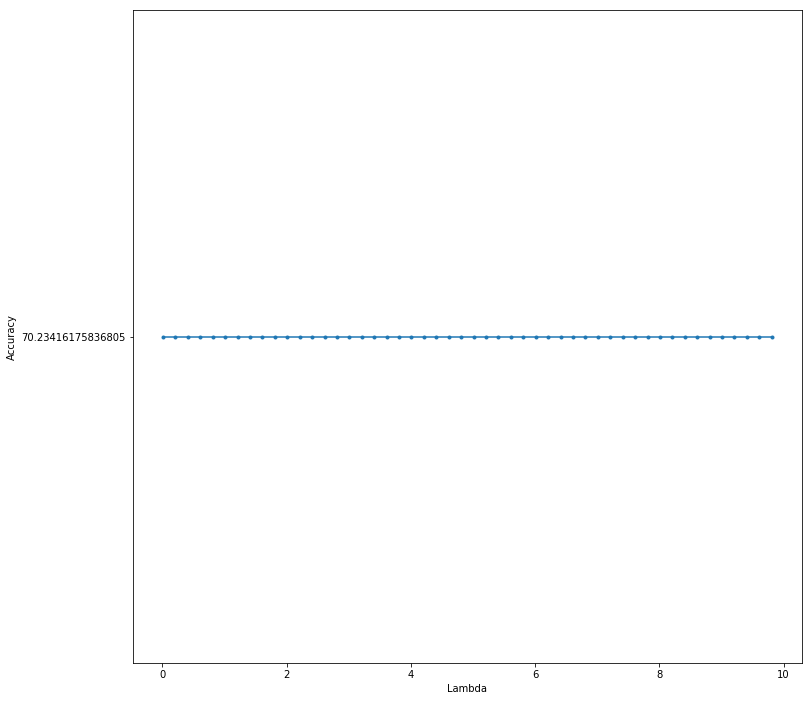

In [9]:
import matplotlib.pyplot as plt
import numpy as np

ErmsArr = []
AccuracyArr = []

ErmsArrTraining = []
ErmsArrValidation = []
ErmsArrTesting = []
MValues = []

AccuracyTraining = []
AccuracyValidation = []
AccuracyTesting = []

LValues = []


#changing values of M from 1-100
# for i in range(1, 100,2):
#     kmeans = KMeans(n_clusters=i, random_state=0).fit(np.transpose(TrainingData))
#     Mu = kmeans.cluster_centers_


#     BigSigma     = GenerateBigSigma(RawData, Mu, TrainingPercent,IsSynthetic)
#     TRAINING_PHI = GetPhiMatrix(RawData, Mu, BigSigma, TrainingPercent)
#     W            = GetWeightsClosedForm(TRAINING_PHI,TrainingTarget,(C_Lambda)) 
#     TEST_PHI     = GetPhiMatrix(TestData, Mu, BigSigma, 100) 
#     VAL_PHI      = GetPhiMatrix(ValData, Mu, BigSigma, 100)

# #     print(Mu.shape)
# #     print(BigSigma.shape)
# #     print(TRAINING_PHI.shape)
# #     print(W.shape)
# #     print(VAL_PHI.shape)
# #     print(TEST_PHI.shape)

#     TR_TEST_OUT  = GetValTest(TRAINING_PHI,W)
#     VAL_TEST_OUT = GetValTest(VAL_PHI,W)
#     TEST_OUT     = GetValTest(TEST_PHI,W)

#     TrainingAccuracy   = str(GetErms(TR_TEST_OUT,TrainingTarget))
#     ValidationAccuracy = str(GetErms(VAL_TEST_OUT,ValDataAct))
#     TestAccuracy       = str(GetErms(TEST_OUT,TestDataAct))
    
#     ErmsArrTraining.append(TrainingAccuracy.split(',')[1])
#     ErmsArrValidation.append(ValidationAccuracy.split(',')[1])
#     ErmsArrTesting.append(ValidationAccuracy.split(',')[1])
#     MValues.append(i)

# #     print ('UBITname      = vgawade')
# #     print ('Person Number = 50290596')
# #     print ('----------------------------------------------------')
# #     print ("------------------LeToR Data------------------------")
# #     print ('----------------------------------------------------')
# #     print ("-------Closed Form with Radial Basis Function-------")
# #     print ('----------------------------------------------------')
# #     print ("M = ",M," \nLambda = ",C_Lambda)
# #     print ("E_rms Training   = " + str(float(TrainingAccuracy.split(',')[1])))
# #     print ("E_rms Validation = " + str(float(ValidationAccuracy.split(',')[1])))
# #     print ("E_rms Testing    = " + str(float(TestAccuracy.split(',')[1])))

Lambd=0.01

kmeans = KMeans(n_clusters=2, random_state=0).fit(np.transpose(TrainingData))
Mu = kmeans.cluster_centers_

while  Lambd<=10:
   


    BigSigma     = GenerateBigSigma(RawData, Mu, TrainingPercent,IsSynthetic)
    TRAINING_PHI = GetPhiMatrix(RawData, Mu, BigSigma, TrainingPercent)
    W            = GetWeightsClosedForm(TRAINING_PHI,TrainingTarget,(Lambd)) 
    TEST_PHI     = GetPhiMatrix(TestData, Mu, BigSigma, 100) 
    VAL_PHI      = GetPhiMatrix(ValData, Mu, BigSigma, 100)

#     print(Mu.shape)
#     print(BigSigma.shape)
#     print(TRAINING_PHI.shape)
#     print(W.shape)
#     print(VAL_PHI.shape)
#     print(TEST_PHI.shape)

    TR_TEST_OUT  = GetValTest(TRAINING_PHI,W)
    VAL_TEST_OUT = GetValTest(VAL_PHI,W)
    TEST_OUT     = GetValTest(TEST_PHI,W)

    TrainingAccuracy   = str(GetErms(TR_TEST_OUT,TrainingTarget))
    ValidationAccuracy = str(GetErms(VAL_TEST_OUT,ValDataAct))
    TestAccuracy       = str(GetErms(TEST_OUT,TestDataAct))
    
    ErmsArrTraining.append(TrainingAccuracy.split(',')[1])
    ErmsArrValidation.append(ValidationAccuracy.split(',')[1])
    ErmsArrTesting.append(TestAccuracy.split(',')[1])
    
    AccuracyTraining.append(TrainingAccuracy.split(',')[0])
    AccuracyValidation.append(ValidationAccuracy.split(',')[0])
    AccuracyTesting.append(TestAccuracy.split(',')[0])
    
    LValues.append(Lambd)
    Lambd+=0.2
    
print(ErmsArrTraining)
print("\n")
print(ErmsArrValidation)
print("\n")
print(ErmsArrTesting)
print("\n")

print(AccuracyTraining)
print("\n")
print(AccuracyValidation)
print("\n")
print(AccuracyTesting)
print("\n")

print(MValues)

print(LValues)
print("\n")

y = ErmsArrTesting
x = LValues
plt.figure(figsize=[12, 12])
plt.ylabel('RMS_E')
plt.xlabel('Lambda')
plt.plot(x,y,marker='.')
plt.show()

y1 = AccuracyTesting
x1 = LValues
plt.figure(figsize=[12, 12])
plt.ylabel('Accuracy')
plt.xlabel('Lambda')
plt.plot(x1,y1,marker='.')
plt.show()

## Gradient Descent solution for Linear Regression

In [10]:
print ('----------------------------------------------------')
print ('--------------Please Wait for 2 mins!----------------')
print ('----------------------------------------------------')

----------------------------------------------------
--------------Please Wait for 2 mins!----------------
----------------------------------------------------


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

W_Now        = np.dot(220, W)
La        = 0.01
learningRate = 0.01
L_Erms_Val   = []
L_Erms_TR    = []
L_Erms_Test  = []
W_Mat        = []

L_Erms_TestAccuracy  = []

Erms_Value   = []
Erms_TRV   = []
Erms_TestV  = []
LaVal= []

Accuracy_TestV  = []


while  learningRate<=1:
    for i in range(0,400):
            #print ('---------Iteration: ' + str(i) + '--------------')
            Delta_E_D     = -np.dot((TrainingTarget[i] - np.dot(np.transpose(W_Now),TRAINING_PHI[i])),TRAINING_PHI[i])
            La_Delta_E_W  = np.dot(La,W_Now)
            Delta_E       = np.add(Delta_E_D,La_Delta_E_W)    
            Delta_W       = -np.dot(learningRate,Delta_E)
            W_T_Next      = W_Now + Delta_W
            W_Now         = W_T_Next

            #-----------------TrainingData Accuracy---------------------#
            TR_TEST_OUT   = GetValTest(TRAINING_PHI,W_T_Next) 
            Erms_TR       = GetErms(TR_TEST_OUT,TrainingTarget)
            L_Erms_TR.append(float(Erms_TR.split(',')[1]))

            #-----------------ValidationData Accuracy---------------------#
            VAL_TEST_OUT  = GetValTest(VAL_PHI,W_T_Next) 
            Erms_Val      = GetErms(VAL_TEST_OUT,ValDataAct)
            L_Erms_Val.append(float(Erms_Val.split(',')[1]))

            #-----------------TestingData Accuracy---------------------#
            TEST_OUT      = GetValTest(TEST_PHI,W_T_Next) 
            Erms_Test = GetErms(TEST_OUT,TestDataAct)
            L_Erms_Test.append(float(Erms_Test.split(',')[1]))
            
            L_Erms_TestAccuracy.append(float(Erms_Test.split(',')[0]))
            

    Erms_Value.append(np.around(min(L_Erms_Val),5))
    Erms_TRV.append(np.around(min(L_Erms_TR),5))
    Erms_TestV.append(np.around(min(L_Erms_Test),5))
    LaVal.append(learningRate)
    
    Accuracy_TestV.append(np.around(min(L_Erms_TestAccuracy),5))
            
    
    print ('----------Gradient Descent Solution--------------------')
    print ("M = "+ str(M) +" \nLambda  = ", La,"\neta= ",learningRate)
    print ("E_rms Training   = " + str(np.around(min(L_Erms_TR),5)))
    print ("E_rms Validation = " + str(np.around(min(L_Erms_Val),5)))
    print ("E_rms Testing    = " + str(np.around(min(L_Erms_Test),5)))
    print ("\n\n\n\n\n\n")
    learningRate+=0.1;
print(Erms_TRV)
print("\n")
print(Erms_Value)
print("\n")
print(Erms_TestV)
print("\n")
print(LaVal)
print("\n")

y = Erms_TestV
x = LaVal
plt.figure(figsize=[12, 12])
plt.ylabel('RMS_E')
plt.xlabel('Lambda')
plt.plot(x,y,marker='.')
plt.show()

y1 = Accuracy_TestV
x1 = LaVal
plt.figure(figsize=[12, 12])
plt.ylabel('Accuracy')
plt.xlabel('Lambda')
plt.plot(x1,y1,marker='.')
plt.show()



# y = [9.79652, 5.9369, 2.31052, 0.79686, 0.63925, 0.63489, 0.63489, 0.63489, 0.63489, 0.63448]
# x = [0.01, 0.11, 0.21000000000000002, 0.31000000000000005, 0.41000000000000003, 0.51, 0.61, 0.71, 0.8099999999999999, 0.9099999999999999]
# plt.figure(figsize=[12, 12])
# plt.ylabel('RMS_E')
# plt.xlabel('Learning rate')
# plt.plot(x,y,marker='.')
# plt.show()